Script to read in exported ArchR data and make AnnData object
https://github.com/dpeerlab/SEACells/blob/main/notebooks/ArchR/ArchR-preprocessing.ipynb

In [2]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import SEACells

In [4]:
# Choose which GUI matplotlib uses to print out plots
#matplotlib.use('TkAgg') # prints them in a separate window
%matplotlib notebook

In [5]:
data_dir = os.path.expanduser('./ArchR_exported_data/')

In [6]:
# Counts data - sparse COO matrix
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')
print(counts.todense()[:10])

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]


In [7]:
# Cell information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
print(cells.head())

1    sample-ss8#CTCAGAACACTGCTCT-1
2    sample-ss8#ACAGACTTCCAGGGAA-1
3    sample-ss8#GGTCATAAGGTAAGTT-1
4    sample-ss8#CATTCCGCAACAACTC-1
5    sample-ss8#CACCTGTGTCAGAAGC-1
Name: x, dtype: object


In [8]:
# Peaks information
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
print(peaks.head())

                 seqnames  start    end  width strand     score  \
chr1:20110-20610     chr1  20110  20610    501      *   65.3472   
chr1:20917-21417     chr1  20917  21417    501      *   26.6971   
chr1:21512-22012     chr1  21512  22012    501      *   17.5530   
chr1:22112-22612     chr1  22112  22612    501      *  106.4140   
chr1:23119-23619     chr1  23119  23619    501      *   49.0126   

                  replicateScoreQuantile  groupScoreQuantile  Reproducibility  \
chr1:20110-20610                   0.921               0.788                2   
chr1:20917-21417                   0.993               0.979                2   
chr1:21512-22012                   0.731               0.351                2   
chr1:22112-22612                   0.964               0.892                2   
chr1:23119-23619                   0.883               0.713                2   

                 GroupReplicate  distToGeneStart nearestGene peakType  \
chr1:20110-20610      C3._.Rep1      

In [9]:
# Make AnnData object
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]
ad.X = ad.X.tocsr()
print(ad)

/var/folders/8d/sqc39h513q7c8gp009fvbv1j1q6xhd/T/ipykernel_23941/449498478.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


AnnData object with n_obs × n_vars = 7409 × 174742
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'name'


In [10]:
# Read in reduced dimensions and add to AnnData
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values
print(ad.obsm)

AxisArrays with keys: X_svd


In [11]:
# Read in cell metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values
print(ad.obs)

                                   Sample  TSSEnrichment  ReadsInTSS  \
x                                                                      
sample-ss8#CTCAGAACACTGCTCT-1  sample-ss8          6.442        2661   
sample-ss8#ACAGACTTCCAGGGAA-1  sample-ss8          5.997        2344   
sample-ss8#GGTCATAAGGTAAGTT-1  sample-ss8          7.234        2656   
sample-ss8#CATTCCGCAACAACTC-1  sample-ss8          7.223        2579   
sample-ss8#CACCTGTGTCAGAAGC-1  sample-ss8          6.471        2549   
...                                   ...            ...         ...   
sample-ss8#CTGGGACAGGCAGATC-1  sample-ss8          7.129          72   
sample-ss8#GGAACTTCAATGGTAA-1  sample-ss8          5.033          61   
sample-ss8#TTGCACCCACTCGGAC-1  sample-ss8          6.371          74   
sample-ss8#CAACGTATCGTCCCTA-1  sample-ss8          7.030          71   
sample-ss8#TTACCCGTCCTCCAGT-1  sample-ss8          7.525          76   

                               ReadsInPromoter  PromoterRatio  

In [12]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [13]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

<IPython.core.display.Javascript object>


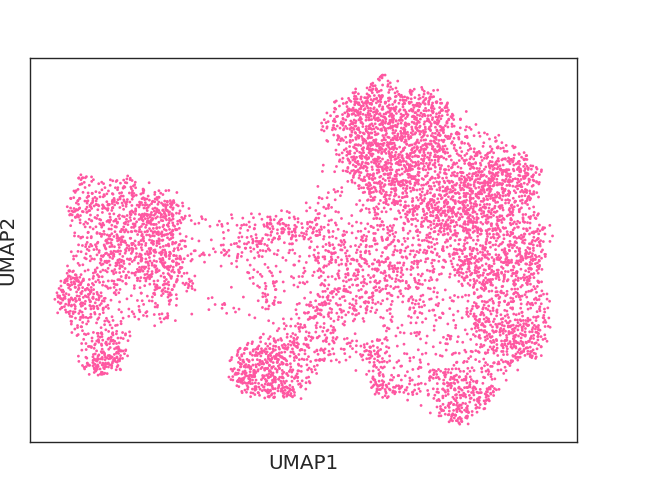

In [17]:
sc.pl.scatter(ad, basis='umap', color= "#fe57a1")

<IPython.core.display.Javascript object>


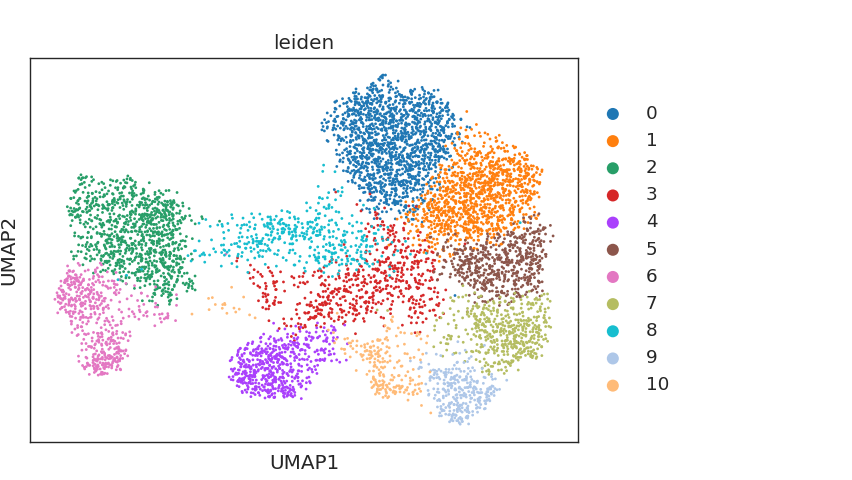

In [19]:
sc.pl.scatter(ad, basis='umap', color='leiden')

In [20]:
ad

AnnData object with n_obs × n_vars = 7409 × 174742
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'stage', 'clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'scHelper_cell_type_new', 'scHelper_cell_type_old', 'rna_stage', 'rna_run', 'rna_clusters', 'ReadsInPeaks', 'FRIP', 'leiden'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'name'
    uns: 'GeneScoresColums', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap'
    obsp: 'distances', 'connectivities'

In [22]:
ad.write(data_dir + '../ss8.h5ad')